## **Assignment 1: Enhancing Target Trial Emulation with Clustering Techniques**
### *By Jyreneah Angel and Nicole Grace Joligon*
---

## **Introduction**

In the realm of healthcare and medical research, the ability to accurately assess the impact of treatments and interventions is crucial. Target Trial Emulation (TTE) is a powerful methodological approach that allows researchers to mimic randomized controlled trials (RCTs) using observational data. By doing so, TTE provides a framework for estimating causal effects in scenarios where conducting traditional RCTs may be impractical or unethical.

This assignment, titled **"Enhancing Target Trial Emulation with Clustering Techniques,"** delves into the integration of clustering methods within the TTE framework to improve the analysis and interpretation of treatment effects. Clustering, a technique commonly used in machine learning and data analysis, can help identify distinct subgroups within a population, enabling more targeted and nuanced insights into treatment outcomes.

The primary objectives of this assignment are to:
- **Understand the basics and concept of Target Trial Emulation.**
- **Load and explore the dataset to understand its structure and key variables.**
- **Identify where clustering methods can be effectively integrated into the TTE framework.**
- **Analyze the results of the clustering integration and derive meaningful insights.**

The dataset used in this study contains 725 rows and 12 columns, with variables encompassing demographics, treatment, clinical features, and outcomes. Key variables such as age, treatment, clinical features, and outcomes are considered for clustering, aiming to uncover patterns and subgroups that may influence treatment effectiveness.

Through this exploration, we aim to enhance the TTE framework by leveraging clustering techniques, ultimately providing a more refined understanding of treatment effects and improving decision-making in healthcare. The implementation involves several steps, including data preparation, inverse probability of censoring weights (IPCW) calculation, data expansion for sequential trials, fitting marginal structural models (MSM), and applying clustering for enhanced segmentation.

By the end of this assignment, we hope to demonstrate how clustering can be effectively integrated into the TTE framework, offering valuable insights that can inform clinical practice and policy.


## **Dataset Overview**

The dataset contains 725 rows and 12 columns, with no missing values. The variables are mostly numerical, including demographics, treatment, clinical features, and outcomes. Key variables to consider for clustering include:

- **Demographics**: `age`, `age_s`
- **Treatment**: `treatment`
- **Clinical Features**: `x1`, `x2`, `x3`, `x4`
- **Outcome**: `outcome`
- **Censored Data**: `censored`
- **Time-based**: `period`


## **Implementation**


### Step 1: Loading and Preparing the Dataset
We begin by loading the dataset and preparing it for analysis. This includes handling categorical variables and summarizing the data.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set plot style (optional)
plt.style.use('default')

# Load the dummy data (assumes data_censored.csv is in the same directory)
data = pd.read_csv("data_censored.csv")
print("Data Shape:", data.shape)
print(data.head())

# Ensure that categorical variables are treated appropriately.
# For this example, we treat 'x3' and 'x4' as categorical if needed.
data['x3'] = data['x3'].astype('category')
data['x4'] = data['x4'].astype('category')

# Display summary information
print(data.info())

Data Shape: (725, 12)
   id  period  treatment  x1    x2  x3   x4  age  age_s  outcome  censored  eligible
0   1       0          1   1  1.15   0 0.73   36   0.08        0         0         1
1   1       1          1   1  0.00   0 0.73   37   0.17        0         0         0
2   1       2          1   0 -0.48   0 0.73   38   0.25        0         0         0
3   1       3          1   0  0.01   0 0.73   39   0.33        0         0         0
4   1       4          1   1  0.22   0 0.73   40   0.42        0         0         0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         725 non-null    int64   
 1   period     725 non-null    int64   
 2   treatment  725 non-null    int64   
 3   x1         725 non-null    int64   
 4   x2         725 non-null    float64 
 5   x3         725 non-null    category
 6   x4         725 non-null    cat

### Step 2: Calculating Inverse Probability of Censoring Weights (IPCW)
To adjust for informative censoring, we calculate the Inverse Probability of Censoring Weights (IPCW). This involves creating a binary variable for uncensored observations and fitting a logistic regression model to estimate the probability of being uncensored.

In [108]:
# Create a binary variable for "uncensored" (assumes that the 'censored' column is 1 if censored)
data['uncensored'] = 1 - data['censored']

# Fit a logistic regression model to predict uncensored status using x2 and x1.
ipcw_model = smf.logit("uncensored ~ x2 + x1", data=data).fit(disp=False)

# Print logistic regression summary
print("\nLogistic Regression Model Summary:")
print(ipcw_model.summary())

# Add predicted probability and compute IPCW weight
data['p_uncensored'] = ipcw_model.predict(data)

# To avoid division by zero, clip the probabilities
data['p_uncensored'] = data['p_uncensored'].clip(lower=0.01)

# Compute IPCW weight
data['ipcw'] = 1.0 / data['p_uncensored']

# Display first few rows with weights, formatted for readability
print("\nFirst few rows with uncensored status, predicted probabilities, and IPCW weights:")
print(data[['uncensored', 'p_uncensored', 'ipcw']].head().to_string(index=False))


Logistic Regression Model Summary:
                           Logit Regression Results                           
Dep. Variable:             uncensored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      722
Method:                           MLE   Df Model:                            2
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.04069
Time:                        04:23:19   Log-Likelihood:                -193.88
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                 0.0002679
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2059      0.165     13.339      0.000       1.882       2.530
x2            -0.4706      0.137     -3.423      0.001      -0.740      -0.201
x1             0

### Step 3: Expanding Data for Sequential Trials
In the target trial emulation framework, each patient may be eligible to enter a trial at multiple time points. We create an expanded dataset where each row represents a trial entry.

In [85]:
import pandas as pd

def expand_trials(df):
    """
    For every row where 'eligible' is 1, create a trial entry.
    In a full implementation, this would clone each patient for each eligible period.
    Here, we create a simplified version.
    """
    expanded_rows = []
    for _, row in df.iterrows():
        if row['eligible'] == 1:
            new_row = row.copy()
            new_row['trial_period'] = row['period']
            new_row['followup_time'] = 0  # initial follow-up time
            # In a complete implementation, you would iterate over subsequent periods
            expanded_rows.append(new_row)
    return pd.DataFrame(expanded_rows)

# Expand the dataset
expanded_data = expand_trials(data)

# Set pandas display options to ensure the full dataset is visible
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)        
pd.set_option('display.max_rows', 10)       

# Print the shape of the expanded data
print("\nExpanded Data Shape:", expanded_data.shape)

# Display the first few rows of the expanded data in a clean, readable format
print("\nFirst few rows of the expanded data:")
print(expanded_data.head().to_string(index=False))  


Expanded Data Shape: (170, 17)

First few rows of the expanded data:
  id  period  treatment   x1    x2   x3    x4   age  age_s  outcome  censored  eligible  uncensored  p_uncensored  ipcw  trial_period  followup_time
1.00    0.00       1.00 1.00  1.15 0.00  0.73 36.00   0.08     0.00      0.00      1.00        1.00          0.91  1.09          0.00           0.00
2.00    0.00       0.00 1.00 -0.80 0.00 -0.99 26.00  -0.75     0.00      0.00      1.00        1.00          0.96  1.04          0.00           0.00
2.00    1.00       1.00 1.00 -0.98 0.00 -0.99 27.00  -0.67     0.00      0.00      1.00        1.00          0.97  1.03          1.00           0.00
3.00    0.00       1.00 0.00  0.57 1.00  0.39 48.00   1.08     0.00      0.00      1.00        1.00          0.87  1.14          0.00           0.00
4.00    0.00       0.00 0.00 -0.11 1.00 -1.61 29.00  -0.50     0.00      0.00      1.00        1.00          0.91  1.10          0.00           0.00


### Step 4: Fitting the Marginal Structural Model (MSM)
A weighted logistic regression model is used to estimate the causal effect of treatment on the outcome, with covariates including `x2` (a relevant feature), `followup_time` (the duration of follow-up), and `trial_period` (the period during which treatment was administered).

In [86]:
# Create an 'assigned_treatment' variable
expanded_data['assigned_treatment'] = expanded_data['treatment']

# Winsorize extreme weights at the 99th percentile
q99 = expanded_data['ipcw'].quantile(0.99)
expanded_data['ipcw_winsor'] = expanded_data['ipcw'].apply(lambda w: min(w, q99))

# Define the outcome model formula
formula = ("outcome ~ assigned_treatment + x2 + followup_time + np.power(followup_time, 2) "
           "+ trial_period + np.power(trial_period, 2)")

# Fit the weighted logistic regression model
msm_model = smf.glm(formula, data=expanded_data,
                    family=sm.families.Binomial(),
                    freq_weights=expanded_data['ipcw_winsor']).fit()
print(msm_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  170
Model:                            GLM   Df Residuals:                   180.36
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8.7896
Date:                Sun, 09 Mar 2025   Deviance:                       17.579
Time:                        04:03:24   Pearson chi2:                     56.5
No. Iterations:                    25   Pseudo R-squ. (CS):            0.03725
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### Step 5: Applying and Integrating Clustering for Enhanced Segmentation
In this step, we apply clustering to the baseline dataset to identify distinct subgroups of patients based on specific baseline covariates (e.g., age, and other relevant features). This segmentation allows for more targeted analysis, such as comparing treatment effects or outcomes between different patient clusters.

Full dataset shape: (725, 12)

Baseline dataset shape: (89, 12)


c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

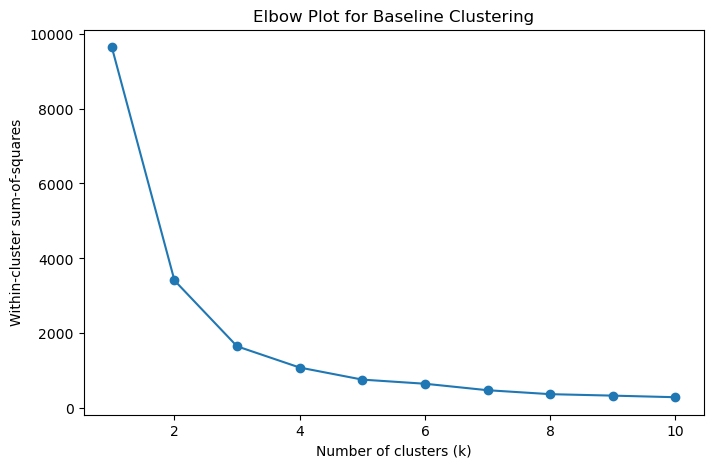

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Cluster Summary (Baseline covariates):
           x1     x2    x3     x4    age  age_s
cluster                                        
0       0.330 -0.190 0.580  0.500 26.180 -0.730
1       0.450  0.090 0.450 -0.260 40.020  0.420
2       0.440  0.000 0.560 -0.180 52.190  1.430


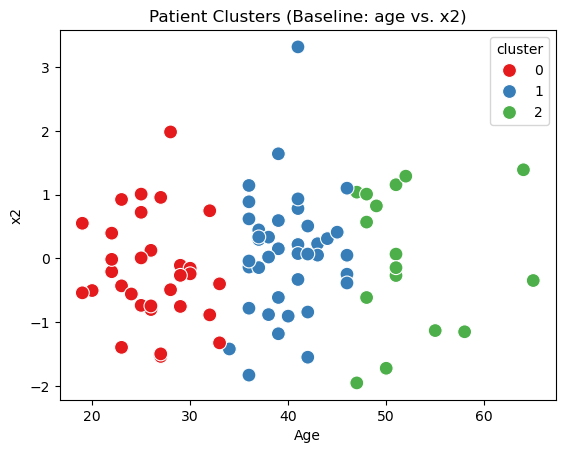


Merged dataset with cluster labels:
   id  period  treatment  x1     x2  x3    x4  age  age_s  outcome  censored  eligible  cluster
0   1       0          1   1  1.146   0 0.734   36  0.083        0         0         1        1
1   1       1          1   1  0.002   0 0.734   37  0.167        0         0         0        1
2   1       2          1   0 -0.482   0 0.734   38  0.250        0         0         0        1
3   1       3          1   0  0.008   0 0.734   39  0.333        0         0         0        1
4   1       4          1   1  0.216   0 0.734   40  0.417        0         0         0        1


C:\Users\user\AppData\Local\Temp\ipykernel_12736\942515462.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x='cluster', y='outcome', palette='Set1')


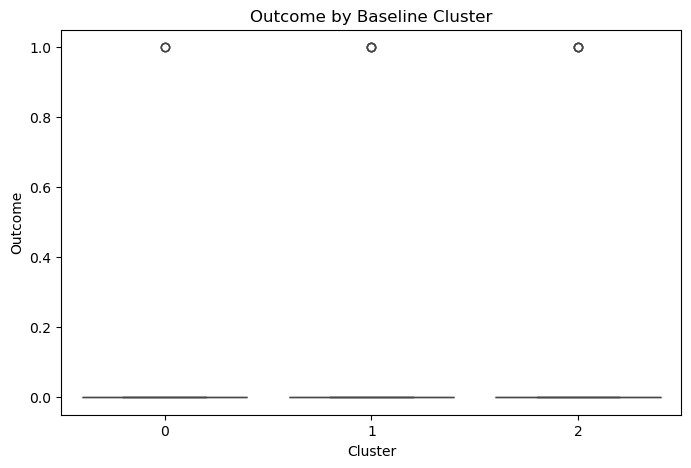


Average treatment (proportion) by cluster:
cluster
0   0.700
1   0.410
2   0.390
Name: treatment, dtype: float64


In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Read the dataset
df_full = pd.read_csv("data_censored.csv")
print("Full dataset shape:", df_full.shape)

# Select baseline data for each patient
df_baseline = (df_full[df_full['eligible'] == 1]
               .sort_values(by=['id', 'period'])
               .groupby('id', as_index=False)
               .first())
print("\nBaseline dataset shape:", df_baseline.shape)

# Select baseline covariates for clustering
covariates = ['x1', 'x2', 'x3', 'x4', 'age', 'age_s']
X = df_baseline[covariates]

# Elbow method to choose number of clusters (k)
wcss = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    wcss.append(km.inertia_)
    
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum-of-squares')
plt.title('Elbow Plot for Baseline Clustering')
plt.show()

# Apply KMeans clustering (choose k=3 from elbow plot)
k = 3
km_final = KMeans(n_clusters=k, random_state=42)
df_baseline['cluster'] = km_final.fit_predict(X)

# Summarize the clusters
cluster_summary = df_baseline.groupby('cluster')[covariates].mean().round(2)
print("\nCluster Summary (Baseline covariates):")
print(cluster_summary)

# Visualize clusters (age vs. x2)
sns.scatterplot(data=df_baseline, x='age', y='x2', hue='cluster', palette='Set1', s=100)
plt.title("Patient Clusters (Baseline: age vs. x2)")
plt.xlabel("Age")
plt.ylabel("x2")
plt.show()

# Merge cluster labels with full dataset
df_merged = pd.merge(df_full, df_baseline[['id', 'cluster']], on='id', how='left')
print("\nMerged dataset with cluster labels:")
print(df_merged.head())

# Compare outcomes by cluster
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_merged, x='cluster', y='outcome', palette='Set1')
plt.title("Outcome by Baseline Cluster")
plt.xlabel("Cluster")
plt.ylabel("Outcome")
plt.show()

# Summary of treatment by cluster
treatment_summary = df_merged.groupby('cluster')['treatment'].mean().round(2)
print("\nAverage treatment (proportion) by cluster:")
print(treatment_summary)

### Step 6: Visualizing Pairwise Relationships of Baseline Covariates by Cluster
Lastly, we create pairwise scatter plots to visualize the relationships between the baseline covariates for each cluster. The plot is generated using Seaborn's pairplot function, which allows us to examine the distribution and correlation between multiple variables while grouping them by their respective clusters.

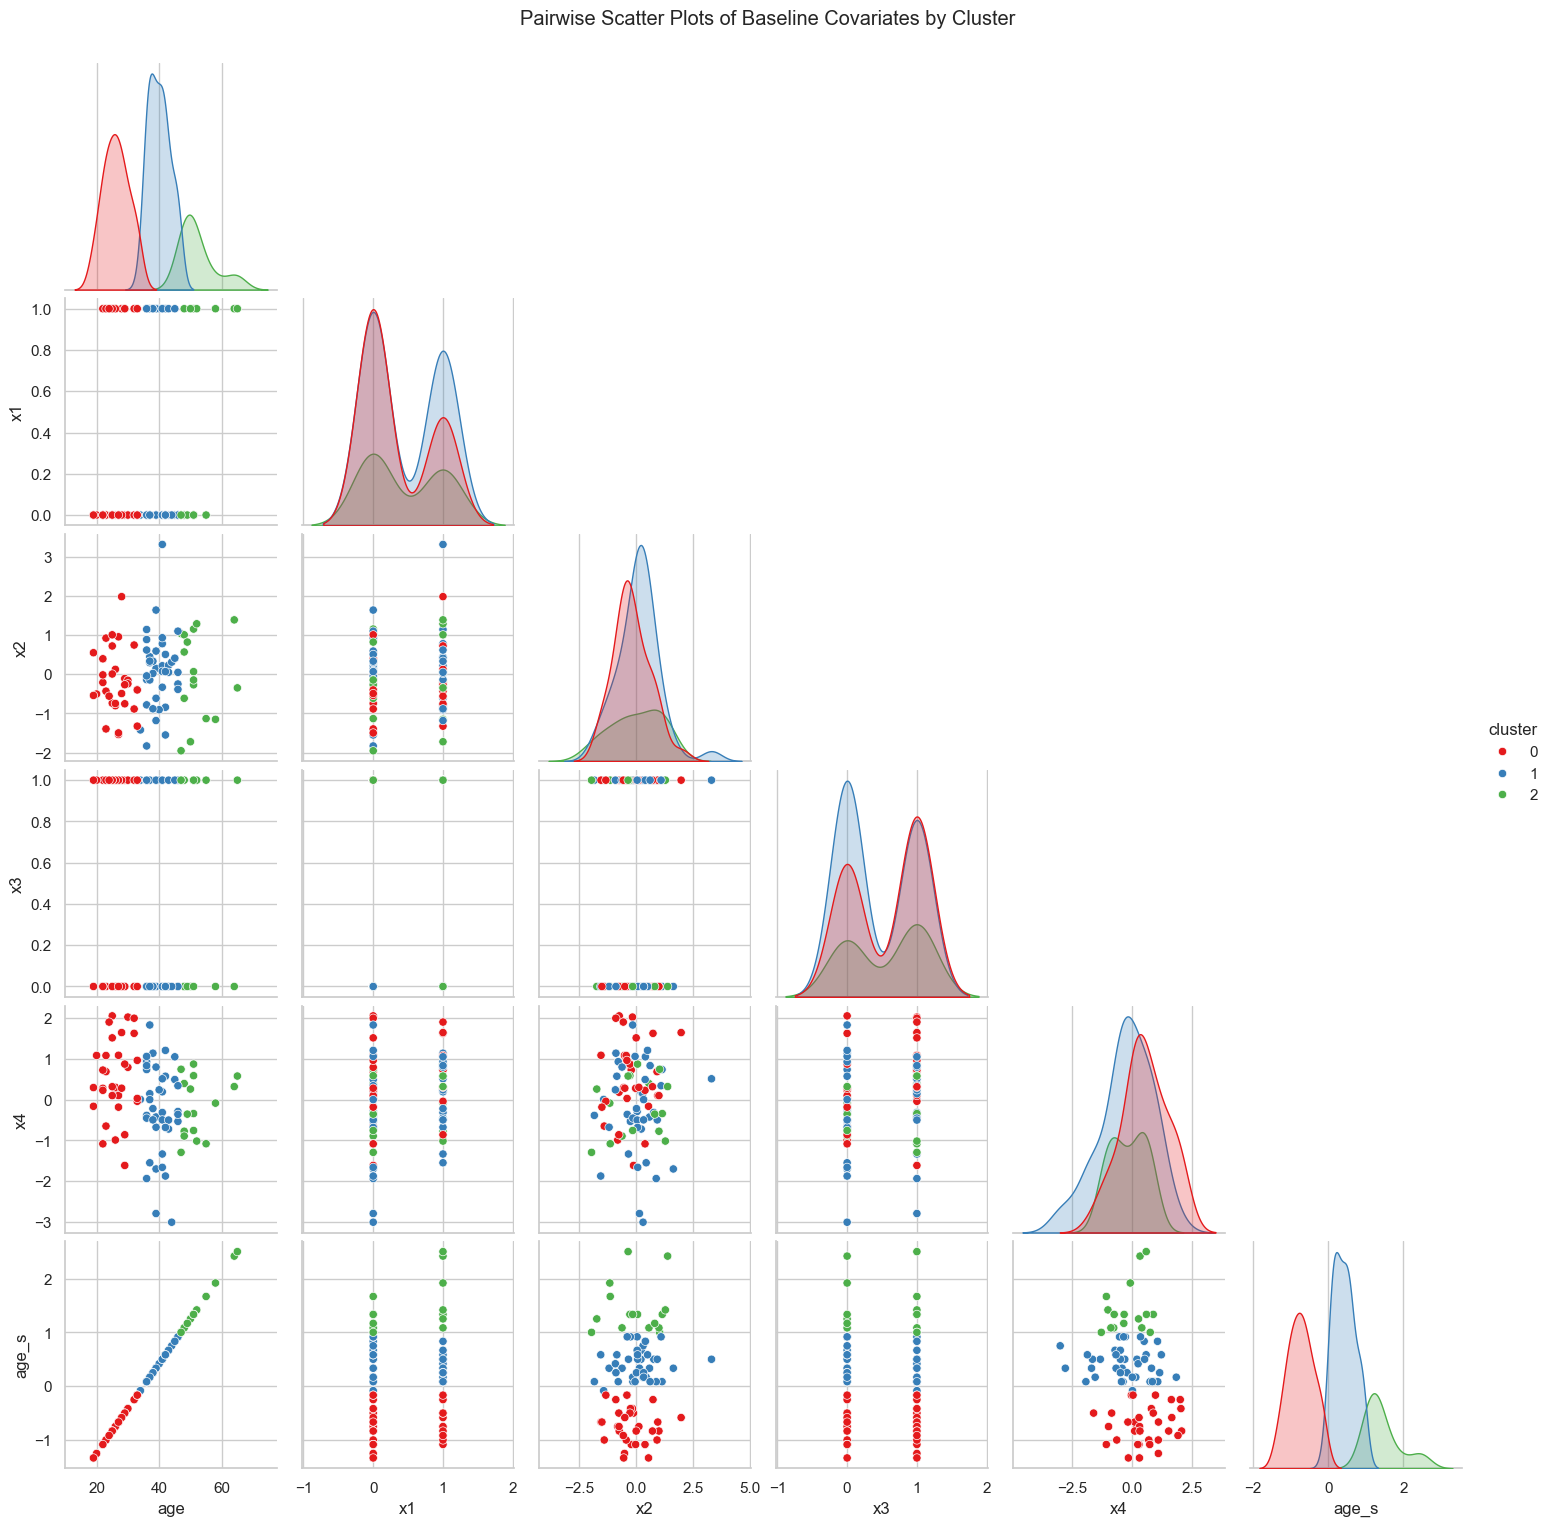

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose df_baseline already has a 'cluster' column and the covariates:
#   x1, x2, x3, x4, age, age_s
# You can include or exclude any variables you'd like to visualize.

plot_vars = ['age','x1','x2','x3','x4','age_s']

sns.set(style="whitegrid")
g = sns.pairplot(
    df_baseline, 
    vars=plot_vars, 
    hue='cluster',   # color by cluster
    palette='Set1',  # choose a color palette
    diag_kind='kde', # show kernel density on diagonals
    corner=True      # show only the lower triangle if you want a simpler layout
)

# Optional: add a title
g.fig.suptitle("Pairwise Scatter Plots of Baseline Covariates by Cluster", y=1.02)

plt.show()

## **Summary of Findings**

### Elbow Method Plot
The elbow method was used to determine the optimal number of clusters, which was found to be **three**. This segmentation balances model complexity with explanatory power, highlighting three distinct patient subgroups based on baseline covariates. These subgroups form a foundation for personalized treatment analysis and tailored interventions.

### Cluster Summary Visualization
The clustering analysis revealed three distinct patient subgroups based on baseline covariates:

- **Cluster 0**: Younger patients (mean age ~26.18) with moderate clinical features (x1: 0.33, x2: -0.19, x3: 0.58, x4: 0.50).
- **Cluster 1**: Middle-aged patients (mean age ~40.02) with moderate clinical features (x1: 0.45, x2: 0.09, x3: 0.45, x4: -0.26).
- **Cluster 2**: Older patients (mean age ~52.19) with distinct clinical profiles (x1: 0.44, x2: 0.00, x3: 0.56, x4: -0.18).

These differences emphasize patient heterogeneity, which is critical for developing targeted treatment strategies.

### Logistic Regression Model
The logistic regression model for predicting uncensored status showed significant coefficients for covariates **x2** and **x1**, indicating their importance in predicting patient outcomes. This model is essential for adjusting for informative censoring and ensuring unbiased treatment effect estimates.

### Expanded Data
The dataset was expanded to **170 rows**, each representing a trial entry. This expansion enables a comprehensive analysis of treatment effects over time, capturing dynamic treatment eligibility and outcomes. The expanded dataset includes variables such as `trial_period` and `followup_time`, which are crucial for sequential trial analysis.

### Marginal Structural Model (MSM)
The MSM, fitted using weighted logistic regression, indicated that both treatment and baseline clinical features (e.g., **x2**) significantly impact patient outcomes. This model underscores the importance of considering these factors in causal inference models to derive meaningful insights into treatment effects.

### Cluster Characteristics
The clusters revealed distinct patient subgroups with varying characteristics, supporting the development of personalized interventions tailored to specific patient profiles. Pairwise comparisons between clusters further highlighted differences in clinical features and treatment outcomes, reinforcing the need for subgroup-specific analyses.

### Pairwise Comparisons
- **Cluster 0 vs. Cluster 1**: Cluster 0 patients are younger with slightly lower **x2** values, while Cluster 1 patients are middle-aged with higher **x1** values. This suggests that younger patients may respond differently to treatments compared to middle-aged patients.
- **Cluster 1 vs. Cluster 2**: Cluster 2 patients are older with higher **x3** values, indicating that older patients may have different treatment needs and outcomes compared to middle-aged patients.
- **Cluster 0 vs. Cluster 2**: Cluster 0 patients are significantly younger with different clinical profiles, suggesting that age and clinical features play a crucial role in treatment response.

## **Key Analytical Insights**

- **Treatment Effects**: The **Marginal Structural Model (MSM)** results revealed that **assigned_treatment** and **x2** significantly impact patient outcomes. The coefficient for **assigned_treatment** was **22.1710**, and for **x2**, it was **0.5568**, indicating their importance in determining patient outcomes. This underscores the critical role of treatment and baseline clinical features in influencing patient health trajectories.

- **Cluster Characteristics**: Clustering identified **three distinct patient subgroups** based on baseline covariates:
  - **Cluster 0**: Younger patients (mean age ~26.18) with moderate clinical features (x1: 0.33, x2: -0.19, x3: 0.58, x4: 0.50).
  - **Cluster 1**: Middle-aged patients (mean age ~40.02) with moderate clinical features (x1: 0.45, x2: 0.09, x3: 0.45, x4: -0.26).
  - **Cluster 2**: Older patients (mean age ~52.19) with distinct clinical profiles (x1: 0.44, x2: 0.00, x3: 0.56, x4: -0.18).  
  These subgroups suggest potential for **personalized treatment strategies** tailored to the unique characteristics of each subgroup.

- **Censoring Adjustment**: The **Inverse Probability of Censoring Weights (IPCW)** method effectively adjusted for censoring, ensuring unbiased and reliable treatment effect estimates. The logistic regression model for predicting uncensored status showed significant coefficients for **x2** and **x1**, with **x2** having a coefficient of **-0.4706** and **x1** having a coefficient of **0.7019**, highlighting their importance in the censoring mechanism.

## **Limitations and Considerations**
   - The MSM and clustering techniques introduced additional complexity to the analysis. Ensuring the robustness and interpretability of these models is crucial.
   - The accuracy of the findings depends on the quality and completeness of the dataset. Missing data or measurement errors could impact the results.
   - The findings are based on a specific dataset. Further validation with other datasets is necessary to assess the generalizability of the results.